In [1]:
from sklearn.datasets import load_iris
from sklearn import tree
import networkx as nx
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%matplotlib inline

In [3]:
iris = load_iris()
clf = tree.DecisionTreeClassifier()
clf.fit(iris.data, iris.target)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

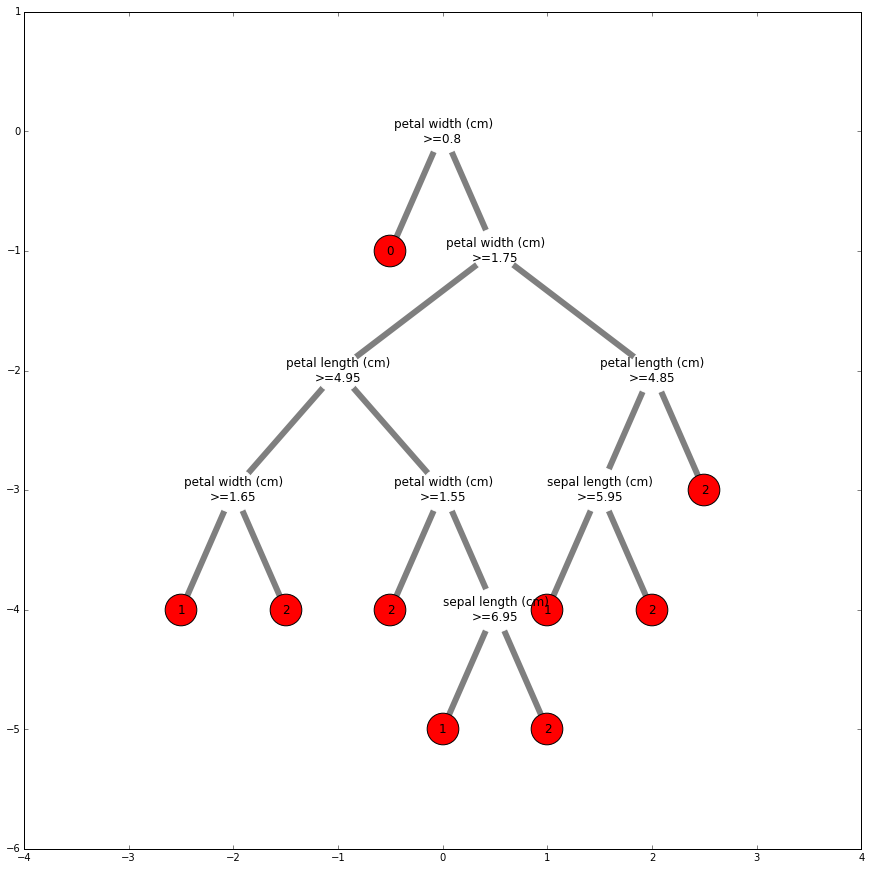

In [251]:
# tree plotting functions
def yloc(tree, node = 0, current = 0):
    '''
    calcualte y values for nodes based on the tree layer
    note: recursive function
    '''
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    # set all values to zero so it will add correctly in recursion
    layers = np.zeros(tree.tree_.node_count)
    layers[node] = current
    # check for terminal node
    if left[node] == -1:
        return layers
    else:
        # find location of child nodes
        return yloc(tree, left[node], current - 1) +\
           yloc(tree, right[node], current - 1) +\
           layers

def xloc(tree, node = 0, parent_x = 0, left_c = False,
         right_c = False, y_level = 0):
    '''
    function to create initial x values for nodes in tree
    these will have to be adjusted if there is any overlap
    note: recursive function
    '''
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    x_cords = np.zeros(tree.tree_.node_count)
    x = parent_x
    # adjust x coordinance if node is left or right child
    if left_c:
        x -= 0.5
    if right_c:
        x += 0.5
    
    x_cords[node] = x
    
    # check for terminal node
    if left[node] == -1:
        return  x_cords
    else:
        # x values for children
        return xloc(tree, left[node], x, left_c = True) +\
            xloc(tree, right[node], x, right_c = True) +\
            x_cords

            
def move_child_nodes(n, x_vec, child_vec, movement):
    x_vec = np.zeros(len(x_vec))
    if child_vec[n][0] != -1:
        x_vec[child_vec[n][0]] += movement
        x_vec[child_vec[n][1]] += movement
        x_vec += move_child_nodes(child_vec[n][0], x_vec,
                                  child_vec, movement)
        
        x_vec += move_child_nodes(child_vec[n][1], x_vec,
                                  child_vec, movement)
        return x_vec
    
    return x_vec

    

def layer_distribute(names, x_vec, y_vec, child_vec,
                     collide = False, l = 1):
    
    collision = lambda i,j: abs(i - j) < 1
    # check for bottom layer
    if l == 1:
        l = y_vec.min()
    
    # find names of current layer
    temp_names = names[y_vec == l]
    
    # center nodes before checking for collisions
    for n in temp_names:
        # center node above children
        if child_vec[n][0] != -1:
            x_vec[n] = (x_vec[child_vec[n][0]] +
                        x_vec[child_vec[n][1]])/2
            
#             print 'centering node %s between %s and %s' % (n, x_vec[child_vec[n][0]], x_vec[child_vec[n][1]])
            
    for n in temp_names:
        for i, n2 in enumerate(temp_names):
            # don't compare node to itself
            if n == n2:
                continue
            
            # lower # nodes should always be to the left
            # if not switch places
            if (n < n2) and (x_vec[n] > x_vec[n2]):
                movement = abs(x_vec[n] - x_vec[n2])
                
                x_vec[n] -= movement
                x_vec[n2] += movement

                x_vec += move_child_nodes(n, x_vec, child_vec, -movement)
                x_vec += move_child_nodes(n2, x_vec, child_vec, movement)
                return layer_distribute(names, x_vec, y_vec, child_vec, False, l)
            
            # check for collision
            if (collision(x_vec[n], x_vec[n2])
               or ((n < n2) and (x_vec[n] > x_vec[n2]))):
#                 print 'moving node %s and %s' % (n, n2), 'locations %s and %s' % (x_vec[n], x_vec[n2])
                
                x_vec[n] -= 0.5
                x_vec[n2] += 0.5

                x_vec += move_child_nodes(n, x_vec, child_vec, -0.5)
                x_vec += move_child_nodes(n2, x_vec, child_vec, +0.5)
                return layer_distribute(names, x_vec, y_vec, child_vec, False, l)
                               
    if l != 0:
#         print '-' * 40
#         print 'starting layer', l+1
#         print {i:j for i,j in enumerate(x_vec)}
        return layer_distribute(names, x_vec, y_vec, child_vec, False, l + 1)
    if collide:
        print '-' * 40
        print 'centering pass'
        return layer_distribute(names, x_vec, y_vec, child_vec)
            
    return x_vec

def plot_tree(tree, feature_names, target_names, round_n = 2):
    '''
    plots a scikit-learn classification tree
    
    input:
        tree - trained decision tree
        feature_names - list of the feature names or column names.
            order is important
        target_names - names of the target class
        round_n - decimal points to round decision rules 
    
    output:
        plot of decision tree
    '''
    plt.figure(figsize = (15,15))
    G=nx.Graph()
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    for i,n in enumerate(left):
        if n != -1:
            G.add_edge(i,n,weight=1)
    for i,n in enumerate(right):
        if n != -1:
            G.add_edge(i,n,weight=1)
        
    labels = {}
    white_nodes = []
    colored_nodes = []
    for i,j in enumerate(tree.tree_.feature):
        if j != -2:
            labels[i] = str(feature_names[j]) + '\n'
            labels[i] += '>=' + str(np.round(tree.tree_.threshold[i],round_n))
            white_nodes.append(i)
        else:
            labels[i] = np.argmax(tree.tree_.value[i])
            colored_nodes.append(i)

    # get y cord of each node
    ys = yloc(tree)
    xs = xloc(tree)
    child_vec = np.array([(l,r) for l,r in zip(left, right)])
    
    xs = layer_distribute(np.array(range(len(ys))), xs, ys, child_vec)
    pos = {abs(int(i)):(xs[i],ys[i]) for i in xrange(len(ys))}

    # draw nodes
    nodes = nx.draw_networkx_nodes(G,pos, nodelist = white_nodes,
                                   node_color = '#FFFFFF',
                                   node_size=2000, node_shape = 'o')
    nodes.set_edgecolor('#FFFFFF')
    
    nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes,
                           node_size=1000)
    # draw edges
    nx.draw_networkx_edges(G,pos,alpha=0.5,width=6)
    # add lables
    nx.draw_networkx_labels(G,pos, labels, font_size=12,
                            font_family='sans-serif')
    # draw node numbers
#     nx.draw_networkx_labels(G,pos, font_size=12,
#                         font_family='sans-serif')
#     plt.axis('off')
    plt.show()
    
plot_tree(clf, iris.feature_names, 0)

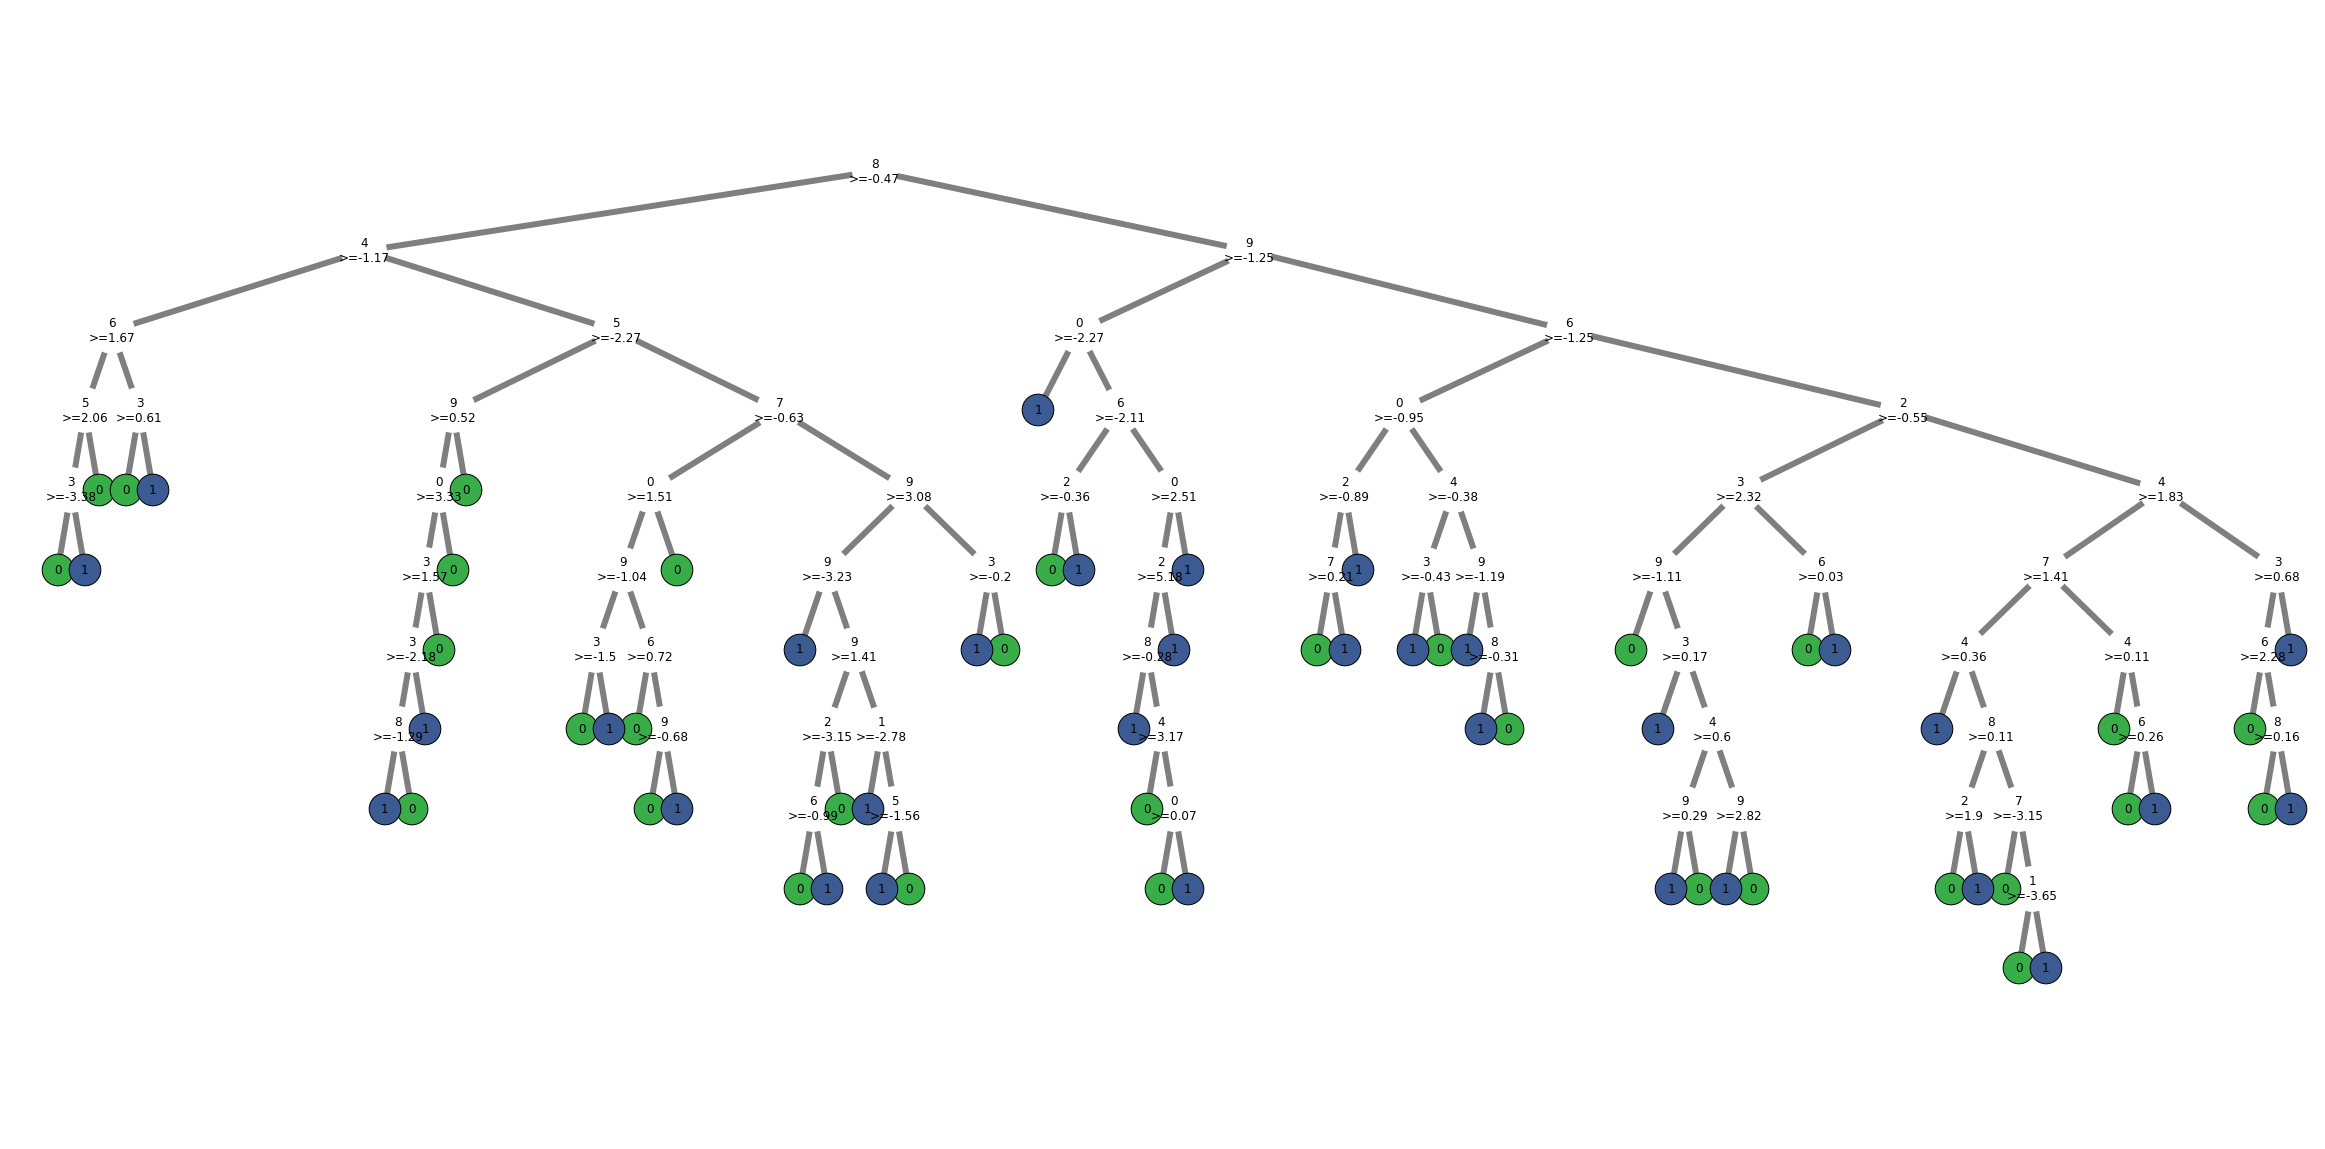

In [47]:
class tree_plot:
    '''
    class to plot decision tree
    this only works for binary trees right now
    '''
    def __init__(self, clf):
        self.tree = clf.tree_
        self.tree_map = {}
        self.left = self.tree.children_left
        self.right = self.tree.children_right
        self.clf = clf
        
        self.map_init()
        self.x_relative(0)
        self.x_abs(0)
        
        
    def map_init(self, node = 0, y = 0, parent = None,
                 l_outer = True, r_outer = True):
        '''
        calcualte y values for nodes based on the tree layer
        note: recursive function
        '''
        left = self.tree.children_left
        right = self.tree.children_right

        # check for terminal node
        if self.left[node] == -1:
            self.tree_map[node] = {
                'y':y,
                'x':0,
                'parent':parent,
                'l_outer':l_outer,
                'r_outer':r_outer,
            }
        else:
            self.tree_map[node] = {
                'y':y,
                'x':0,
                'parent':parent,
                'l_outer':l_outer,
                'r_outer':r_outer,
                
                'r_child':self.right[node],
                'l_child':self.left[node],
            }
            
            self.map_init(node = self.right[node], y = y-1,
                          parent = node, l_outer = False, r_outer = r_outer)
            self.map_init(node = self.left[node], y = y-1,
                          parent = node, l_outer = l_outer, r_outer = False)
            
            
    def right_dist(self, node, count = 0):
        '''
        estimates how far right the children of node will go
        '''

        distance = []
        if self.left[node] == -1:
            return [count]
        else:
            distance.extend(self.right_dist(self.left[node], count - 1))
            distance.extend(self.right_dist(self.right[node], count + 1))

        return distance

    def left_dist(self, node, count = 0):
        '''
        estimates how far right the children of node will go
        '''
        distance = []
        if self.left[node] == -1:
            return [count]
        else:
            distance.extend(self.left_dist(self.left[node], count + 1))
            distance.extend(self.left_dist(self.right[node], count - 1))

        return distance

    def x_relative(self, node):
        '''
        calculates the x position of a node relative to its parent
        '''
        # check if terminal node
        if self.left[node] == -1:
            return
        
        ldist = max(self.left_dist(self.right[node]))
        rdist = max(self.right_dist(self.left[node]))
#         print 'node: %s, ldist: %s, rdist: %s' % (node, ldist, rdist)
        if ldist < 1 or rdist < 1:
            seperation = 0.5
        else:
            seperation = ((ldist + rdist)/2.0)
            if not (self.tree_map[node]['l_outer'] and 
            self.tree_map[node]['r_outer']):
                self.split_widen(self.tree_map[node]['parent'], seperation)
        # calculate needed seperation
        self.tree_map[self.right[node]]['x'] += seperation
        self.tree_map[self.left[node]]['x'] -= seperation
        # recursively call child nodes
        self.x_relative(self.right[node])
        self.x_relative(self.left[node])
        
    def split_widen(self, node, seperation):
        '''
        increase the seperating distance in a split when needed
        '''
        # if node is an outer node, add all the seperation to that node
        if self.tree_map[node]['l_outer']:
            self.tree_map[node]['x'] -= seperation
            self.tree_map[self.left[node]]['x'] -= seperation/2.0
            self.tree_map[self.right[node]]['x'] += seperation/2.0
            return
            
        if self.tree_map[node]['r_outer']:
            self.tree_map[node]['x'] += seperation
            self.tree_map[self.left[node]]['x'] -= seperation/2.0
            self.tree_map[self.right[node]]['x'] += seperation/2.0
            return
        
        self.tree_map[self.left[node]]['x'] -= seperation/2.0
        self.tree_map[self.right[node]]['x'] += seperation/2.0
        self.split_widen(self.tree_map[node]['parent'], seperation)
            
        
        
    def x_abs(self, node = 0, x = 0):
        '''
        sums the relative x position to find absolute x position
        '''
        x += self.tree_map[node]['x']
        self.tree_map[node]['x_abs'] = x 
        
        if self.left[node] == -1:
            return
        
        self.x_abs(self.right[node], x)
        self.x_abs(self.left[node], x)
        
    
    def plot(self, feature_names, round_n = 2,
             colors = ['#39ad48', '#3b5b92']):
        '''
        actual plot function
        '''
        # find appropriate dimensions for the plot
        x_max = max(self.tree_map[n]['x_abs'] for n in self.tree_map)
        x_min = min(self.tree_map[n]['x_abs'] for n in self.tree_map)
        x_size = x_max - x_min
        y_size = max(abs(self.tree_map[n]['y']) for n in self.tree_map)
        plt.figure(figsize = (x_size/2, y_size*2))
        # initialize networkx plot
        G = nx.Graph()
        # add edges
        for i,n in enumerate(self.left):
            if n != -1:
                G.add_edge(i,n,weight=1)
        for i,n in enumerate(self.right):
            if n != -1:
                G.add_edge(i,n,weight=1)

        labels = {}
        white_nodes = []
        colored_nodes_0 = []
        colored_nodes_1 = []
        # node lables
        for i,j in enumerate(self.tree.feature):
            # if node is a decision it should be white
            if j != -2:
                labels[i] = str(feature_names[j]) + '\n'
                labels[i] +='>=' + str(np.round(self.tree.threshold[i],round_n))
                white_nodes.append(i)
            # if node is terminal it should be colored
            # only works for binary decision trees
            elif np.argmax(self.tree.value[i]) == 0:
                labels[i] = np.argmax(self.tree.value[i])
                colored_nodes_0.append(i)
            else:
                labels[i] = np.argmax(self.tree.value[i])
                colored_nodes_1.append(i)
        # build location map for nodes
        pos = {int(i):(self.tree_map[i]['x_abs'], self.tree_map[i]['y'])
               for i in xrange(len(self.tree_map))}

        # draw nodes
        nodes = nx.draw_networkx_nodes(G,pos, nodelist = white_nodes,
                                       node_color = '#FFFFFF',
                                       node_size=2000, node_shape = 'o')
        # remove decision node borders
        nodes.set_edgecolor('#FFFFFF')
        # add colored nodes
        nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes_0,
                               node_size=1000, node_color = colors[0])
        nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes_1,
                       node_size=1000, node_color = colors[1])
        # draw edges
        nx.draw_networkx_edges(G,pos,alpha=0.5,width=6)
        # add lables
        nx.draw_networkx_labels(G,pos,labels,font_size=12,font_family='sans-serif')
        plt.axis('off')
        plt.xlim(min(pos[x][0] for x in pos)-1, max(pos[x][0] for x in pos)+1)
        plt.show()
        
            
my_tree = tree_plot(clf)
my_tree.plot(range(len(X)))


In [39]:
from sklearn.datasets import make_classification

X, y = make_classification(n_samples=500,
                           n_features=10,
                           n_informative=10,
                           n_redundant=0,
                           n_repeated=0,
                           n_classes=2,
                           random_state=0,
                           shuffle=False)

clf = tree.DecisionTreeClassifier()
clf.fit(X, y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None, min_samples_leaf=1,
            min_samples_split=2, min_weight_fraction_leaf=0.0,
            random_state=None, splitter='best')

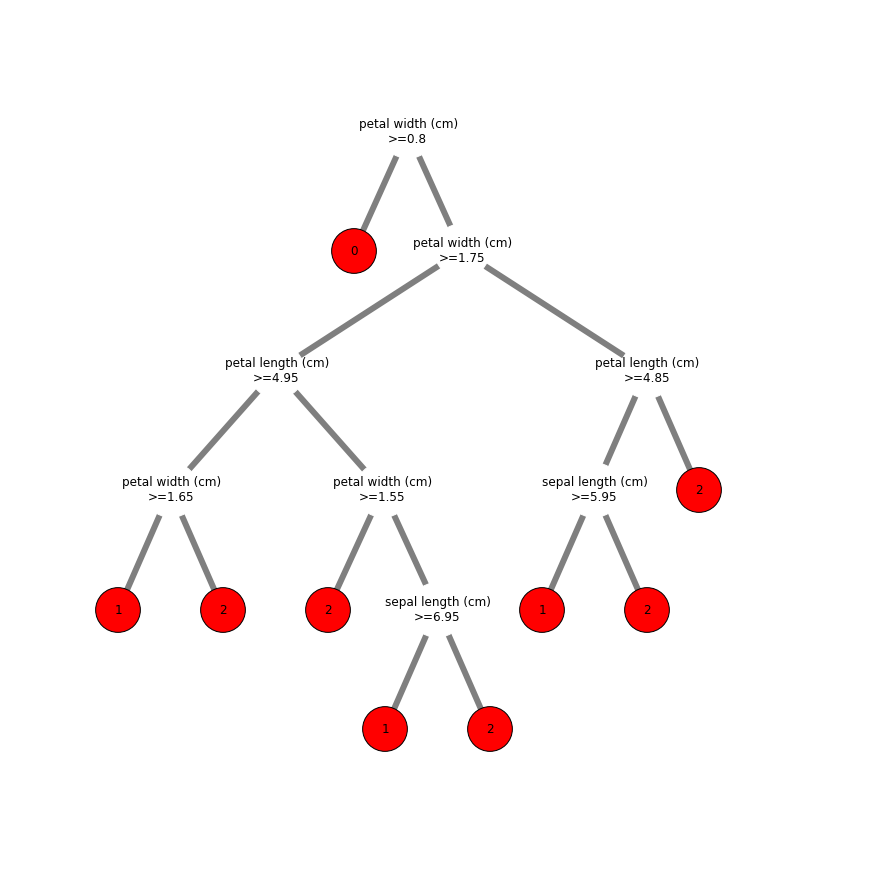

In [247]:
def plot_tree(tree, feature_names, target_names, round_n = 2):
    plt.figure(figsize = (15,15))
    G=nx.Graph()
    left = tree.tree_.children_left
    right = tree.tree_.children_right
    for i,n in enumerate(left):
        if n != -1:
            G.add_edge(i,n,weight=1)
    for i,n in enumerate(right):
        if n != -1:
            G.add_edge(i,n,weight=1)
        
    labels = {}
    white_nodes = []
    colored_nodes = []
    for i,j in enumerate(tree.tree_.feature):
        if j != -2:
            labels[i] = str(feature_names[j]) + '\n'
            labels[i] += '>=' + str(np.round(tree.tree_.threshold[i],round_n))
            white_nodes.append(i)
        else:
            labels[i] = np.argmax(tree.tree_.value[i])
            colored_nodes.append(i)

    # get y cord of each node
    ys = yloc(tree)
    xs = xloc(tree)
    child_vec = np.array([(l,r) for l,r in zip(left, right)])
    
    xs = layer_distribute(np.array(range(len(ys))), xs, ys, child_vec)
#     print xs
    pos = {abs(int(i)):(xs[i],ys[i]) for i in xrange(len(ys))}

    # draw nodes
    nodes = nx.draw_networkx_nodes(G,pos, nodelist = white_nodes,
                                   node_color = '#FFFFFF',
                                   node_size=3000, node_shape = 'o')
    nodes.set_edgecolor('#FFFFFF')
    
    nx.draw_networkx_nodes(G,pos, nodelist = colored_nodes,
                           node_size=2000)
    # draw edges
    nx.draw_networkx_edges(G,pos,alpha=0.5,width=6)
    # add lables
    nx.draw_networkx_labels(G,pos,labels,font_size=12,font_family='sans-serif')
    plt.axis('off')
    plt.show()
    
plot_tree(clf, iris.feature_names, 0)

In [9]:
for i,j in enumerate(clf.tree_.feature):
    if j >= 0:
        print i, iris.feature_names[j]
        print '\t threshold:',clf.tree_.threshold[i]
    else:
        print i

0 petal width (cm)
	 threshold: 0.800000011921
1
2 petal width (cm)
	 threshold: 1.75
3 petal length (cm)
	 threshold: 4.94999980927
4 petal width (cm)
	 threshold: 1.65000009537
5
6
7 petal width (cm)
	 threshold: 1.54999995232
8
9 petal length (cm)
	 threshold: 5.44999980927
10
11
12 petal length (cm)
	 threshold: 4.85000038147
13 sepal length (cm)
	 threshold: 5.94999980927
14
15
16


In [10]:
for i,j in enumerate(clf.tree_.weighted_n_node_samples):
    print i, j

0 150.0
1 50.0
2 100.0
3 54.0
4 48.0
5 47.0
6 1.0
7 6.0
8 3.0
9 3.0
10 2.0
11 1.0
12 46.0
13 3.0
14 1.0
15 2.0
16 43.0


In [8]:
terms = []
terms = filter(lambda x: x != 'a', terms)
''.join(x+',' for x in terms)

''